In [3]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline # Later WHAT FLAVOUR
import statsmodels.formula.api as smf

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Evaluation metrics for regression problems

Evaluation metrics are useful for explaining the accuracy of our models, comparing different models, and deciding which variables to include into a model.

Let's create some example numeric predictions, and calculate three common evaluation metrics for regression problems:

In [4]:
# define true and predicted response values
y_true = [100, 50, 30, 20]
y_pred = [90, 50, 50, 30]

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

In [5]:
print metrics.mean_absolute_error(y_true, y_pred)

10.0


**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

In [6]:
print metrics.mean_squared_error(y_true, y_pred)

150.0


**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [7]:
print np.sqrt(metrics.mean_squared_error(y_true, y_pred))
print metrics.mean_squared_error(y_true, y_pred) ** 0.5

12.2474487139
12.2474487139


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units. # interpreted in Y units

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [6]:
# same true values as above
y_true = [100, 50, 30, 20]

# new set of predicted values
y_pred = [60, 50, 30, 20]

# MAE is the same as before
print metrics.mean_absolute_error(y_true, y_pred)

# RMSE is larger than before
print np.sqrt(metrics.mean_squared_error(y_true, y_pred))

10.0
20.0


### Computing evaluation metrics for our linear model on the advertising dataset

Let's compute these evaluation metrics for the linear model we have developed for our advertising dataset

In [8]:
# read data into a DataFrame
advert = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
advert.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [9]:
factors = ["TV", "Radio", "Newspaper"]
X = advert[factors]
y = advert["Sales"]

In [11]:
lm = smf.ols(formula="Sales ~ TV + Radio + Newspaper", data=advert).fit() # lm = linear regression model
sales_preds = lm.predict(X)

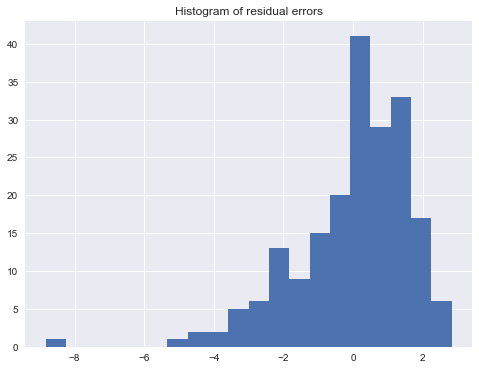

In [13]:
plt.figure(figsize=(8,6))
plt.hist(y - sales_preds, bins=20)
plt.title("Histogram of residual errors")
plt.show()
# looking and checking for residual errors. Notive errors past 0

Plotting the residual errors provides us a useful indication of how our model is performing. Ideally, we would like the errors to be normally distributed around zero with minimal variance.

In [16]:
print "R squared:", lm.rsquared
print "Adjusted R squared:", lm.rsquared_adj
print "MAE:", metrics.mean_absolute_error(y, sales_preds)
print "MSE:", metrics.mean_squared_error(y, sales_preds)
print "RMSE:", np.sqrt(metrics.mean_squared_error(y, sales_preds)) 
#thousand of widgets sold. indicates 1000 to 2000 widgets error. Out of 50,000 sold or so. Refer to last data set

R squared: 0.897210638179
Adjusted R squared: 0.89563733162
MAE: 1.25201122969
MSE: 2.78412631451
RMSE: 1.66857014072


Our model looks pretty good, with a fairly low RMSE. Remember that the model is fitted to minimize squared errors, but we don't know how it will perform on unseen or new data.

### Bias vs Variance

Let's explore the problem of overfitting, looking at an extreme example. We first generate a hypothetical function which represents a ground truth along with some random noise.

In [17]:
func = lambda x: (x-5)**2 
noise = lambda x: np.random.normal(scale=5.0, size=len(x))

In [20]:
n = 10
x_sample = np.linspace(0, 15, n) #linspace generating space - n values between 0 to 15. Just dummy DATA GENERATION IGNORE
y_sample = func(x_sample) + noise(x_sample) 
df = pd.DataFrame({'x': x_sample, 'y': y_sample})

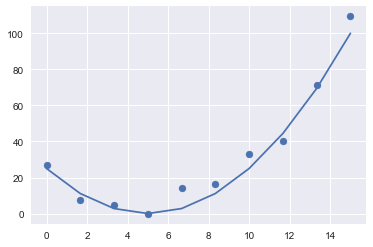

In [21]:
plt.scatter(x_sample, y_sample)
plt.plot(x_sample, func(x_sample))
plt.show()

We then proceed to construct three models of varying complexity by creating additional polynomial features.

**PolynomialFeatures**: Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

We will cover pipelines in more detail in future lessons 

**Pipelines**: Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

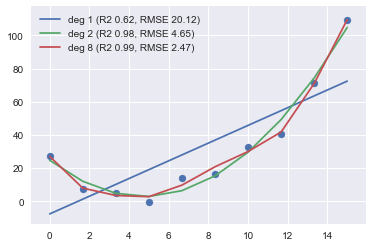

In [22]:
degrees = [1,2,8]
models = []
for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(df[['x']], df['y'])
    y_pred = model.predict(df[['x']])
    plt.plot(df[['x']], y_pred, label="deg %d (R2 %.2f, RMSE %.2f)" %
             (degree, model.score(df[['x']], df['y']), np.sqrt(metrics.mean_squared_error(df['y'], y_pred))))
    models.append(model)
    
plt.scatter(x_sample, y_sample)    
plt.legend()
plt.show()

The most complex model with the highest polynomial features has the lowest RMSE but it may just be overfitting the data and connecting all the dots. 

- It's actually a result from algebra that you can fit *any* finite set of data points with a polynomial. 
- In fact, for any set of $n$ data points, there exists a polynomial of degree $n$ that goes right through them.
- This is great if you want to approximate your data arbitrarily closely.
- It's not great if you are afraid of overfitting your data

Let's test the models against some new data.

In [23]:
n = 50
x_test = np.linspace(0, 15, n)
y_test = func(x_test) + noise(x_test) 
df_test = pd.DataFrame({'x': x_test, 'y': y_test})

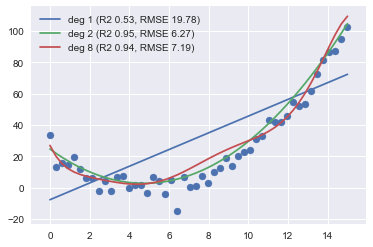

In [24]:
for degree, model in zip(degrees, models):
    y_pred = model.predict(df_test[['x']])
    plt.plot(df_test[['x']], y_pred, label="deg %d (R2 %.2f, RMSE %.2f)" % 
             (degree, model.score(df_test[['x']], df_test['y']), 
              np.sqrt(metrics.mean_squared_error(df_test['y'], y_pred))))
plt.legend()
plt.scatter(x_test, y_test)    
plt.show()

The first model is biased as a linear model isn't able to fully capture the quadratic relationship. The model with a high number of degrees has overfitted the training set and doesn't perform well on previously unseen data.  

### Model Evaluation

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [30]:
train, test = model_selection.train_test_split(advert, test_size=0.4, random_state=50)
train.shape, test.shape

((120, 4), (80, 4))

In [26]:
lm_overfit = smf.ols(formula="Sales ~ I(TV ** 2) + I(TV ** 3) + I(TV ** 4) + I(TV ** 5) \
             + I(Radio ** 2) + I(Radio ** 3) + I(Radio ** 4) + I(Radio ** 5) \
             + I(Newspaper ** 2) + I(Newspaper ** 3) + I(Newspaper ** 4) + I(Newspaper ** 5)", data=train).fit()
#lm_overfit.summary()

In [31]:
lm_simple = smf.ols(formula="Sales ~ TV + Radio + Newspaper", data=train).fit()
#lm_simple.summary()

In [32]:
print "Overfitted Model Training MSE: %f" % metrics.mean_squared_error(lm_overfit.predict(train), train["Sales"])
print "Simple Model Training MSE: %f" % metrics.mean_squared_error(lm_simple.predict(train), train["Sales"])

Overfitted Model Training MSE: 2.139992
Simple Model Training MSE: 3.160282


In [33]:
print "Overfitted Model Test MSE: %f" % metrics.mean_squared_error(lm_overfit.predict(test), test["Sales"])
print "Simple Model Test MSE: %f" % metrics.mean_squared_error(lm_simple.predict(test), test["Sales"])

Overfitted Model Test MSE: 4.719033
Simple Model Test MSE: 2.408094


### Cross Validation 

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

In [38]:
n = 30
x_sample = np.linspace(0, 15, n) # linspace is generic generation of random numbers in order
y_sample = func(x_sample) + noise(x_sample) 
df = pd.DataFrame({'x': x_sample, 'y': y_sample})

In [37]:
kf.split(df).next()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 19,
        20, 22, 23, 25, 26, 27, 29]), array([12, 14, 18, 21, 24, 28]))

In [40]:
kf = model_selection.KFold(n_splits=5, shuffle=True)
for degree in [1, 2, 8]:
    print "Degree", degree #x^n or whatever slope
    rmse_values = []
    scores = []
    models = []
    n = 0
    for train_index, test_index in kf.split(df): #'kf' is an iterater (different set of training and test indices each time)- pass data into it as an object. 
        n += 1
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
        y_pred = model.predict(df.iloc[test_index][['x']])
        rmse_values.append(np.sqrt(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"])))
        scores.append(model.score(df[['x']], df['y']))
        print 'Model', n
        print 'RMSE:', rmse_values[n-1]
        print 'R2:', scores[n-1]

    print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
    print 'Mean of RMSE for all folds:', np.mean(rmse_values)
    print 'Mean of R2 for all folds:', np.mean(scores)
    print

Degree 1
Model 1
RMSE: 26.7328805064
R2: 0.56100983756
Model 2
RMSE: 14.6140825819
R2: 0.571655070648
Model 3
RMSE: 23.0447991958
R2: 0.571133767487
Model 4
RMSE: 27.7308249303
R2: 0.540748401691
Model 5
RMSE: 11.440205733
R2: 0.569123951692
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 20.7125585895
Mean of R2 for all folds: 0.562734205816

Degree 2
Model 1
RMSE: 4.06547194453
R2: 0.967608586202
Model 2
RMSE: 4.55177491504
R2: 0.967751177863
Model 3
RMSE: 6.49602079223
R2: 0.967215053803
Model 4
RMSE: 5.05977487558
R2: 0.967886073684
Model 5
RMSE: 7.92244195687
R2: 0.966381850153
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of RMSE for all folds: 5.61909689685
Mean of R2 for all folds: 0.967368548341

Degree 8
Model 1
RMSE: 15.7555690416
R2: 0.924793885473
Model 2
RMSE: 5.24000870101
R2: 0.967566503351
Model 3
RMSE: 7.70781394466
R2: 0.965590215397
Model 4
RMSE: 10.6504929849
R2: 0.960323458023
Model 5
RMSE: 5.49170424855
R2: 0.966669050908
~~~~ SUMMARY OF CROSS VALI

### Cross Validation on the advertising dataset

In [42]:
rmse_list = []
n = 0
for train_index, test_index in kf.split(advert): # splitting up the advertising dataset
    n += 1
    train = advert.iloc[train_index] # Returns all the data that have been split and is relevant to this case.
    test = advert.iloc[test_index]
    lm = smf.ols(formula = "Sales ~ TV + Radio + Newspaper", data=train).fit() # stats model to train the data
    ypreds = lm.predict(test[["TV", "Radio", "Newspaper"]]) # running the prediction on the test data
    rmse = np.sqrt(metrics.mean_squared_error(ypreds, test["Sales"])) #computing difference in the errors
    rmse_list.append(rmse)
    print "Model %d RMSE: %f" % (n, rmse)
print "Average RMSE:", np.mean(rmse_list)

Model 1 RMSE: 1.596953
Model 2 RMSE: 1.534505
Model 3 RMSE: 2.177538
Model 4 RMSE: 1.557254
Model 5 RMSE: 1.525739
Average RMSE: 1.67839779306


### Using Sklearn

Let's practice cross validation and construct the model this time using Sklearn

In [43]:
rmse_list = []
n = 0
for train_index, test_index in kf.split(advert):
    n += 1
    train = advert.iloc[train_index]
    test = advert.iloc[test_index]
    model = LinearRegression().fit(train[["TV", "Radio", "Newspaper"]], train["Sales"])
    ypreds = model.predict(test[["TV", "Radio", "Newspaper"]])
    rmse = np.sqrt(metrics.mean_squared_error(ypreds, test["Sales"]))
    rmse_list.append(rmse)
    print "Model %d RMSE: %f" % (n, rmse)
print "Average RMSE:", np.mean(rmse_list)
#generally take all RMSE do indivual predictions for it and then average out the predictions

Model 1 RMSE: 1.709354
Model 2 RMSE: 2.281684
Model 3 RMSE: 1.559981
Model 4 RMSE: 1.551372
Model 5 RMSE: 1.399290
Average RMSE: 1.70033633745


### Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

### Cross-validation recommendations

- K can be any number, but **K = 5 or 10** is generally recommended
- For classification problems, **stratified sampling** is recommended for creating the folds i.e. Each response class should be represented with equal proportions in each of the K folds - Good representative sample in each split

### Regularization 

If your model is very complex (i.e., lots of features, possibly a polynomial fit, etc.), you need to worry more about overfitting.
- You'll need regularization when your model is complex, which happens when you have little data or many features.
- We'll fit the (unregularized) `LinearRegression`, as well as the (regularized) `Ridge` and `Lasso` model.
  - Lasso regression imposes an L1 prior on the coefficient, causing many coeffiecients to be zero.
  - Ridge regression imposes an L2 prior on the coefficient, causing outliers to be less likely, and coeffiecients to be small across the board.

Let's revisit the hypothetical model we created earlier and see if applying regularization can prevent the overfitting we previously observed with high polynomial features.

In [48]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
n = 30
x_sample = np.linspace(0, 15, n)
y_sample = func(x_sample) + noise(x_sample) 
df = pd.DataFrame({'x': x_sample, 'y': y_sample})

In [49]:
mse_values = []
for train_index, test_index in kf.split(df):
    degree = 10
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()).fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
    y_pred = model.predict(df.iloc[test_index][['x']])
    mse_values.append(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"]))
print 'RMSE: ', np.sqrt(np.mean(mse_values))

RMSE:  7.96433861755


### Ridge Regression 

In [50]:
alphas = np.logspace(-4, 4, 9) #range of tuning variablles to play around with 
for alpha in alphas:
    mse_values = []
    for train_index, test_index in kf.split(df):
        degree = 10
        model = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha)).fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
        y_pred = model.predict(df.iloc[test_index][['x']])
        mse_values.append(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"]))
    print 'Alpha: %f RMSE: %f' % (alpha, np.sqrt(np.mean(mse_values)))

Alpha: 0.000100 RMSE: 6.382594
Alpha: 0.001000 RMSE: 6.371105
Alpha: 0.010000 RMSE: 6.501328
Alpha: 0.100000 RMSE: 6.613498
Alpha: 1.000000 RMSE: 7.970956
Alpha: 10.000000 RMSE: 10.678306
Alpha: 100.000000 RMSE: 13.278796
Alpha: 1000.000000 RMSE: 24.531363
Alpha: 10000.000000 RMSE: 29.140532


### Lasso 

In [51]:
alphas = np.logspace(-4, 4, 9)
for alpha in alphas:
    mse_values = []
    for train_index, test_index in kf.split(df):
        degree = 10
        model = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Lasso(alpha)).fit(df.iloc[train_index][['x']], df.iloc[train_index]['y'])
        y_pred = model.predict(df.iloc[test_index][['x']])
        mse_values.append(metrics.mean_squared_error(y_pred, df.iloc[test_index]["y"]))
    print 'Alpha: %f RMSE: %f' % (alpha, np.sqrt(np.mean(mse_values)))

Alpha: 0.000100 RMSE: 6.397653
Alpha: 0.001000 RMSE: 6.398671
Alpha: 0.010000 RMSE: 6.416968
Alpha: 0.100000 RMSE: 6.920365
Alpha: 1.000000 RMSE: 9.141255
Alpha: 10.000000 RMSE: 13.842468
Alpha: 100.000000 RMSE: 29.793609
Alpha: 1000.000000 RMSE: 29.793609
Alpha: 10000.000000 RMSE: 29.793609


### Bonus: We can use GridSearch to automate all this! 

In [52]:
pipe = make_pipeline(PolynomialFeatures(10), StandardScaler(), Lasso())
alphas = np.logspace(-4, 4, 9)
gs = model_selection.GridSearchCV(
    estimator=pipe,
    param_grid={'lasso__alpha': alphas},
    scoring='neg_mean_squared_error',
    cv=kf)

gs.fit(df[['x']], df['y'])

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=10, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [53]:
gs.best_estimator_

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=10, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [54]:
gs.best_params_

{'lasso__alpha': 0.0001}

In [55]:
gs.best_score_

-40.929969621261804

In [56]:
np.sqrt(-gs.best_score_)

6.3976534464803425